# ショアのアルゴリズム

ショア(Shor)のアルゴリズムは、多項式時間で整数を因数分解することで有名です。最もよく知られている古典的なアルゴリズムは、2つの素数の積の因数分解に超多項式時間が必要です。よって、広く使われている暗号システムRSAは、十分大きな整数の場合、因数分解が不可能であることを前提としています。

この章では、ショアのアルゴリズムの量子部分に焦点を当てます。それは、実際には、_周期発見_ の問題を解きます。因数分解の問題は多項式時間の周期発見問題に変換できるため、ショアのアルゴリズムによる効率的な周期発見アルゴリズムを使用して整数を効率的に因数分解することができます。
$a^x\bmod N$ の周期を効率的に計算できれば、効率的に因数分解できることを示すのに十分です。周期発見はそれ自体で価値のある問題なので、最初にこれを説明し、次にこれを使用して5章でどのように因数分解できるかについて説明します。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
from tabulate import tabulate
from fractions import Fraction
print("Imports Successful")

Imports Successful


## 1. 問題: 周期発見

周期関数を見てみましょう：

$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>注意: モジュロ(Modulo) &amp; モジュラー演算 (ここをクリックして開く)</summary>


モジュロ演算（「mod」と省略）は、ある数値を別の数値で割ったときの剰余を見つけることを意味します。例えば：

$$ 17 \bmod 5 = 2 $$

$17 \div 5 = 3$ なので、余りは$2$ です（つまり、$17 = (3\times 5) + 2$）。 Pythonでは、モジュロ演算は<code>%</code> 記号で示されます。 
    
この動作は、数値が特定の値（モジュラス）に達した後に数値が「折り返される」<a href="https://en.wikipedia.org/wiki/Modular_arithmetic">モジュラー演算</a>で使用されます。モジュラー演算を使用して、次のように書くことができます：

$$ 17 = 2 \pmod 5$$

ここで、$\pmod 5$ は、式の左側にのみ適用される上記の式とは異なり、（括弧内にあるため）式全体に適用されます。
</details>

ここで、$a$ と$N$ は正の整数で、$a$ は$N$ 未満であり、共通の因数はありません。周期または次数($r$) は、次の式を満たす最小（ゼロ以外）の整数です：

$$a^r \bmod N = 1 $$ 

以下のグラフに、この関数の例を示します。 ポイント間の線は周期性を確認するためのものであり、x印の間の中間値を表していないことに注意してください。

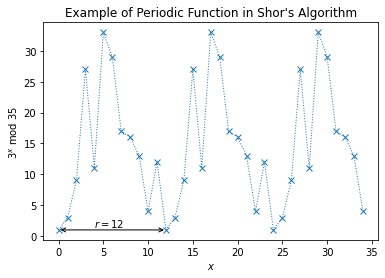

In [2]:
N = 35
a = 3

# プロットするデータを計算する
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# matplotlibを使って描画
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # グラフ上にrをプロット
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

## 2. 解法

ショアの解決策は、以下のユニタリー演算子において[量子位相推定](./quantum-phase-estimation.html)を使用します：

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

これがどのように役立つかを確認するために、Uの固有状態がどのように見えるかを考えてみましょう。$|1\rangle$の状態から開始した場合、Uが連続して適用され、つまり、レジスターの状態に$a \pmod N$ を乗算します。Uを$r$ 回適用すると、再び状態$|1\rangle$になることがわかります。たとえば、$a = 3$ および$N = 35$ の場合：

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

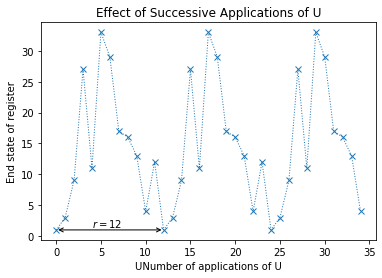

In [3]:
ax.set(xlabel='UNumber of applications of U', ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

したがって、このサイクルの重ね合わせ（$|u_0\rangle$）は、$U$の固有状態になります：

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$


<details>
    <summary>クリックして開く：$a = 3$ 、 $N=35$のときの例</summary>

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$
</details>


この固有状態は、固有値1を持ちますが、これでは問題があまり面白くありません。より面白い固有状態は、これらの各計算基底の状態にそれぞれ対応した位相を持つものでしょう。具体的に、$k$番目の状態の位相が$k$に比例する場合を見てみましょう：

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

<details>
    <summary>クリックして開く：$a = 3$ 、 $N=35$のときの例</summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

(位相の分母に$r = 12$ が現れていることがわかります。)
</details>

これは$r$を含むため、特に興味深い固有値です。実際、$r$は、$r$個の計算基底の状態間の位相差が等しくなるようにセットされる必要があります。上記の状態はこの振る舞いをする唯一の固有状態ではありません。一般化するために、整数$s$をこの位相差にかけると、欲しい固有値が出てきます： 

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

<details>
    <summary>クリックして開く：$a = 3$ 、 $N=35$のときの例</summary>

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i s}{12}}|9\rangle + e^{-\tfrac{4\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|12\rangle + e^{-\tfrac{22\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle + e^{-\tfrac{6\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i s}{12}}|12\rangle + e^{-\tfrac{24\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}$$

</details>

これで、$0 < s < r-1$である$s$の整数値ごとに固有の固有状態がでました。これらの固有状態をすべて合計すると、さまざまな位相で、$|1\rangle$ を除くすべての計算基底の状態がキャンセルされます：

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

<details>
    <summary>クリックして開く：$a = 7$ 、 $N=15$のときの例</summary>

ここでは、$a = 7$ と $N=15$ の小さな例を見てみましょう。$r=4$の場合に：
    
$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>

計算基底の状態$|1\rangle$ がこれらの固有状態の重ね合わせであるため、状態$|1\rangle$ を使用して$U$に対してQPE(量子位相推定)を実行すると、位相が測定されます：

$$\phi = \frac{s}{r}$$

ここで、$s$は$0$ と$r-1$ の間のランダムな整数です。最後に、$\phi$の[連分数アルゴリズム](https://en.wikipedia.org/wiki/Continued_fraction) を使用して$r$ を見つけます。回路図は次のようになります(ここではビット配列がQiskitの量子ビット順を使っています。)：

<img src="images/shor_circuit_1.svg">

次に、Qiskitのシミュレーターでショアのアルゴリズムを紹介します。このデモでは、説明なしで$U$ の回路を与えますが、4章で、$U^{2^j}$の回路を効率的に構築する方法について説明します。

## 3. Qiskit での実装

この例では、$a=7$ と$N=15$ の周期発見問題を解きます。 $U$を以下のようにセットしたときの回路を与えます：

$$U|y\rangle = |ay\bmod 15\rangle $$

ここでは説明はありませんが、$U^x$ を作成するには、この回路を$x$ 回繰り返します。 次の章で、これらの回路を効率的に作成する一般的な方法について説明します。 関数`c_amod15` は、`a` に関して制御Uゲートを`power` 回繰り返します。

In [4]:
def c_amod15(a, power):
    """mod 15による制御ゲートをかける"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

測定用ビットとして8量子ビットを使います：

In [5]:
# Specify variables
n_count = 8 # number of counting qubits
a = 7

また、逆QFTの回路も与えます（詳細については、[量子フーリエ変換の章](./quantum-fourier-transform.html#generalqft)を参照してください）：

In [6]:
def qft_dagger(n):
    """n量子ビットの逆QFTを回路の最初のn量子ビットにかける"""
    qc = QuantumCircuit(n)
    # Swapsを忘れない!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

これらの構成要素があれば、ショアのアルゴリズムの回路を簡単に構築することができます：

In [7]:
# n_count個の測定用量子ビットとUを操作するための4量子ビットで
# 量子回路を作る
qc = QuantumCircuit(n_count + 4, n_count)

# 測定用量子ビットを
# |+>状態に初期化
for q in range(n_count):
    qc.h(q)
    
# アンシラレジスターを|1>の状態にする
qc.x(3+n_count)

# 制御Uを操作
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# 逆QFTを操作
qc.append(qft_dagger(n_count), range(n_count))

# 回路を測定
qc.measure(range(n_count), range(n_count))
qc.draw('text')

┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐»
 q_8: ─────┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c_0: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_1: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_2: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_3: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_4: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_5: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_6: ═════════════════════════════════════════════════════════════════»
                                                                       »
 c_7: ═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■────

結果として何が測定されるか見てみましょう：

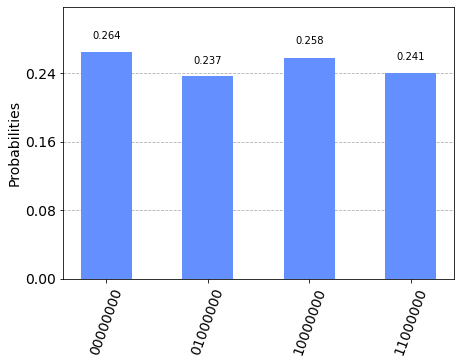

In [8]:
backend = Aer.get_backend('aer_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

3つの量子ビットがあるため、これらの結果は次の測定された位相に相当します：

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # 2進数を10進数に変換します
    phase = decimal/(2**n_count) # 固有値を探します
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加します：
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# tabulateを使って、ASCIIテーブルとして行を印刷します：
print(tabulate(rows, 
               headers=["Register Output", "Phase"], 
               colalign=("left","right")))

Register Output                    Phase
------------------------  --------------
00000000(bin) = 0(dec)      0/256 = 0.00
10000000(bin) = 128(dec)  128/256 = 0.50
11000000(bin) = 192(dec)  192/256 = 0.75
01000000(bin) = 64(dec)    64/256 = 0.25


次に、連分数アルゴリズムを使用して、$s$と$r$を見つけることができます。 Pythonの組み込みの`fractions`(分数)モジュールを使用して、浮動小数点を`Fraction`オブジェクトに変換できます。例えば：

In [10]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [11]:
5998794703657501/9007199254740992

0.666

これは、正確な結果（この場合は、`0.6660000...`）を返す分数をが得られるため、上のようなやっかいな結果になる可能性があります。`.limit_denominator()` メソッドを使って、分母が特定の値を下回る、浮動小数点に最も近い分数を取得します。

In [12]:
# 分母が15未満の
# 0.666に最も近い分数を取得
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

ずっといいですね！次数(r)はN未満でなければならないので、最大分母を`15`に設定します。

In [13]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# ASCIIテーブルを表示
print(tabulate(rows, 
               headers=["Phase", "Fraction", "Guess for r"], 
               colalign=('right','right','right')))

  Phase    Fraction    Guess for r
-------  ----------  -------------
      0         0/1              1
    0.5         1/2              2
   0.75         3/4              4
   0.25         1/4              4


測定された固有値のうちの2つが正しい結果を与えたことがわかります：$r=4$。そしてショアのアルゴリズムが失敗する可能性があることもわかります。これらの悪い結果は、$s = 0$、または$s$と$r$が素数ではなく、$r$の代わりに$r$の因数が与えられるためです。これに対する最も簡単な解決策は、$r$について満足のいく結果が得られるまで実験を繰り返すことです。

### 簡単な演習

- 上記の回路を$a = 2, 8, 11$ の値に変更します。どのような結果が得られますか?またその理由は何ですか?

## 4. 剰余指数化

$U$を繰り返すことによって$U^{2^j}$ゲートを作成する方法は、$j$とともに指数関数的に増加し、多項式時間のアルゴリズムにはなりません。演算子を作成する方法が必要です：

$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$

これは、$j$とともに多項式に成長します。 幸いなことに、以下の計算：

$$ a^{2^j} \bmod N$$

は効率的に可能です。古典コンピューターでは、 _反復二乗_ と呼ばれるアルゴリズムを使用して指数を計算できます。 この例では、$2^j$の形式の指数のみを扱っているため、反復二乗アルゴリズムは非常に単純になります：

In [14]:
def a2jmodN(a, j, N):
    """二乗を繰り返してa^{2^j} (mod N) を計算"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [15]:
a2jmodN(7, 2049, 53)

47

Pythonで効率的なアルゴリズムが可能であれば、量子コンピューターで同じアルゴリズムを使用できます。残念ながら、$j$で多項式にスケーリングしても、モジュラー指数回路は単純ではなく、ショアのアルゴリズムのボトルネックになっています。初心者にやさしい実装は、参考文献[1]にあります。

## 5. 周期発見から因数分解へ

すべての因数分解の問題が難しいわけではありません；偶数をすぐに見つけて、その因数の1つが2であることが分かる場合もあります。実際、因数分解が難しい数値を選択するための[特定の基準](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf#%5B%7B%22num%22%3A127%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C70%2C223%2C0%5D)がありますが、基本的な考え方は、2つの大きな素数の積を選択することです。

一般的な因数分解アルゴリズムは、まず、その整数を因数分解するための近道があるかどうかを確認します（つまり、その数が偶数かどうか？$N = a^b$ の形をしていないか？を確認します）。その後、最悪のシナリオの場合にショアの周期発見を使います。アルゴリズムの量子部分に焦点を合わせることを目的としているため、Nが2つの素数の積である場合を考えます。

### 例: 15の因数分解

小さな量子ビット数での因数分解の例を示すために、15を因数分解します。これは、それほど大きくない素数3と5の積であることは誰もが知っています。

In [16]:
N = 15

最初のステップは、$1$ から $N-1$ の間の乱数 $x$ を選択することです：

In [17]:
np.random.seed(1) # 再現可能な結果が確実に得られるようにするため
a = randint(2, 15)
print(a)

7


次に、$N$ の自明でない因数でないことをすばやく確認します：

In [18]:
from math import gcd # 最大公約数
gcd(a, 15)

1

素晴らしい。次に、`a = 7`および`N = 15`に対してショアの位相発見アルゴリズムを実行します。測定する位相は$s/r$ になることに注意してください。ここで、

$$ a^r \bmod N = 1 $$

であり、$s$ は0と$r-1$ の間のランダムな整数です。

In [19]:
def qpe_amod15(a):
    n_count = 3
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # 測定用量子ビットを|+>に初期化
    qc.x(3+n_count) # アンシラレジスターを|1>に
    for q in range(n_count): # 制御Uを行う
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # 逆QFTを行う
    qc.measure(range(n_count), range(n_count))
    # 結果をシミュレート
    backend = Aer.get_backend('aer_simulator')
    # 以下でmemory = Trueに設定し、各順次読み取りのリストを表示できます
    result = execute(qc, backend, shots=1, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

この位相から、$r$を簡単に推定することができます：

In [20]:
np.random.seed(3) #  再現可能な結果が確実に得られるようにするため
phase = qpe_amod15(a) # 位相 = s/r
phase.as_integer_ratio() # 分母が（うまくいけば！）rを教えてくれます

Register Reading: 000
Corresponding Phase: 0.000000


(0, 1)

In [21]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

1


これで$r$が出たので、これを使って$N$の因数を見つけることができるかもしれません：

$$a^r \bmod N = 1 $$

よって：

$$(a^r - 1) \bmod N = 0 $$

これは、$N$ が$a^r-1$を割るという意味です。 そして、$r$ が偶数の場合でも、次のように書くことができます：

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

($r$が偶数でない場合、先に進むことはできず、別の値の$a$で再試行する必要があります。) その場合、$a^{r/2}-1$ または$a^{r/2}+1$ の最大公約数が$N$ の因数である確率が高くなります[2]。

In [22]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[15, 1]


以下のセルは、15の因数が少なくとも1つ見つかるまでアルゴリズムを繰り返します。セルを数回再実行して、セルの動作を確認する必要があります。

In [23]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # 位相 = s/r
    frac = Fraction(phase).limit_denominator(15) # 分母は（うまくいけば！）私たちにrを伝えます
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # 因数をgcd(x^{r/2} ±1 , 15)から推定します
        guesses = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess != 1 and (15 % guess) == 0: # 推定した因数が正しいか確認します
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 110
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


## 6. 参考文献

1. Stephane Beauregard, _Circuit for Shor's algorithm using 2n+3 qubits,_ [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, _Quantum Computation and Quantum Information,_ Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)

In [24]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}